In [0]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms

In [0]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [0]:
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
]) 

In [0]:
test_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
])

In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Udacity_DL/Dataset/CIFAR-10"
batch_size = 8
num_workers = 2

In [74]:
trainset = datasets.CIFAR10(root=data_dir,
                            train=True,
                            download=True,
                            transform=train_transform)

Files already downloaded and verified


In [75]:
testset = datasets.CIFAR10(root=data_dir,
                            train=False,
                            download=True,
                            transform=test_transform)

Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = num_workers)

In [0]:
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [0]:
dataloaders = {
    'train' : trainloader,
    'test' : testloader
} 

In [0]:
total_batch_sizes = {'train' : len(trainloader), 'test' : len(testloader)}

In [0]:
dataset_sizes = {'train' : len(trainloader), 'test' : len(testloader)}

In [81]:
dataset_sizes

{'test': 1250, 'train': 6250}

In [82]:
class_names = trainset.classes

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#Importing Model

In [0]:
from torchvision import models

In [0]:
model = models.resnet18(pretrained=True)

In [85]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Freezing Model Parameters of above trained model

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [87]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [0]:
model.fc  = nn.Linear(num_ftrs, 10)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [90]:
print(device)

cuda:0


In [91]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Training

In [0]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

  model = model.to(device)

  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):

    print("Epoch {}/{}".format(epoch, num_epochs-1))
    print("_"*10)

    for phase in ['train', 'test']:

      if phase == 'train':
        scheduler.step()
        model.train()

      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in dataloaders[phase]:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)

          _, preds = torch.max(outputs, 1)

          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / total_batch_sizes[phase]
      epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print('Training Complete')

  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model         

In [94]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
__________


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 29.3973 Acc: 0.4146
test Loss: 19.4804 Acc: 0.6105
Training Complete
Best val Acc: 0.4146


In [95]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [96]:
with torch.no_grad():

  correct = 0
  total = 0

  for images, labels in dataloaders['test']:

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on test images: {}%".format(100*correct/total))  

Accuracy of the model on test images: 61.05%


In [0]:
def imshow(inp, title):

  inp = inp.cpu().numpy().transpose((1, 2, 0))
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)

  plt.figure(figsize=(12, 6))

  plt.imshow(inp)
  plt.title(title)
  plt.pause(5)

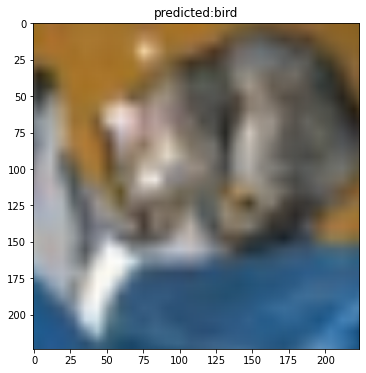

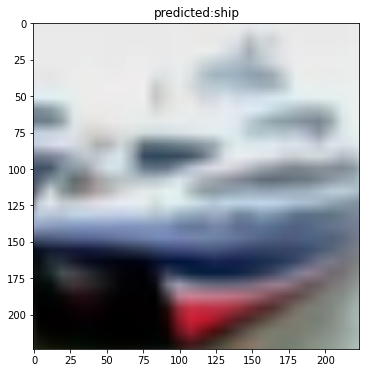

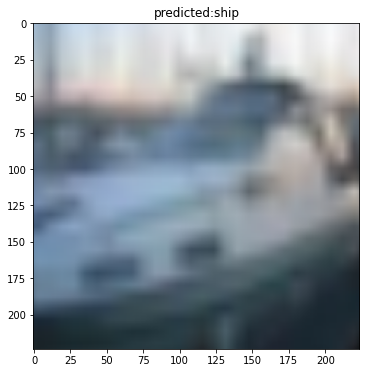

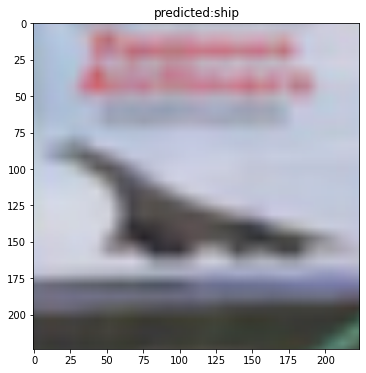

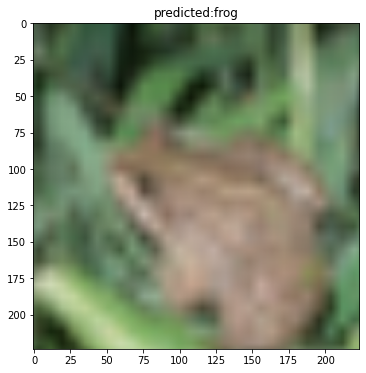

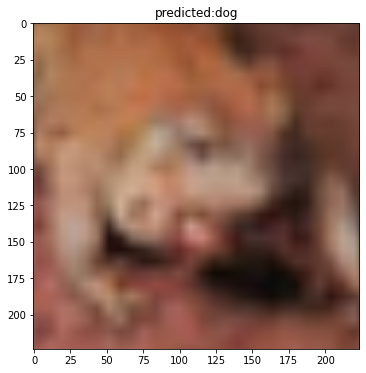

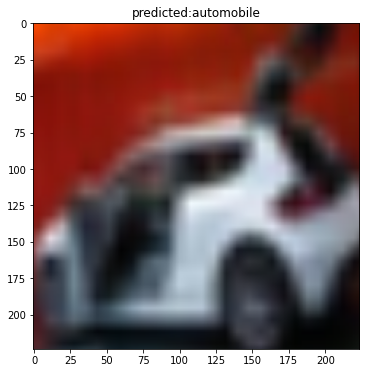

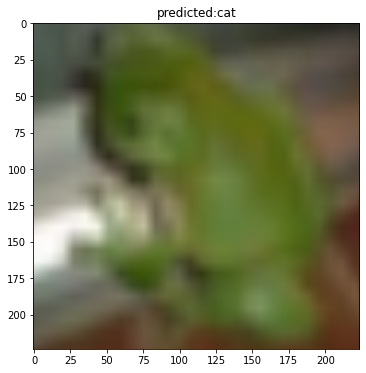

In [98]:
with torch.no_grad():

  inputs, labels = iter(dataloaders['test']).next()

  inputs = inputs.to(device)
  labels = labels.to(device)


  inp = torchvision.utils.make_grid(inputs)

  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)

  for j in range(len(inputs)):
    inp = inputs.data[j]
    imshow(inp, 'predicted:' + class_names[preds[j]])  